# Markov Chain Analysis of Mouse Movement by Node
Load unrewarded mouse trajectory data by node.
Then overlay this on binary tree.
Animate the mouse movement along this binary tree by timestep.

## Imports

In [17]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
from tree import *
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Import the 'bct' package from R
bct = importr("BCT")

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2
np.set_printoptions(threshold=np.inf)

## Plan
1. For a given unrewarded mouse, remove 20% of the trajectories, use the other 80% for training.
2. Use `SplitModeClips` function to grab all explore clips from that mouse.
3. Turn each of these clips into action clips where the actions are 0 for in-left, 1 for in-right, 2 for out. Concatenate these together with a `-1` symbol to indicate a reset to the start. 
4. Feed this time series into the BCT package in R to predict mouse movement, and then to find changepoints.

In [18]:
def ModeMask(tf,ma,re):
    '''
    Creates an array that parallels the bouts in tf giving the behavioral mode for every state
    0=home,1=drink,2=explore
    '''
    cl=SplitModeClips(tf,ma,re) # split the trajectory into mode clips
    # ex is just a list of [0,1,2] in the shape of tf.
    ex=[np.zeros(len(b)) for b in tf.no]
    # each entry in ex determines the mode of that state.
    # its a time series too.
    for c in cl: 
        ex[c[0]][c[1]:c[1]+c[2]]=c[3]
    return ex

In [19]:
def freqCalc(m, contexts, sequence):
    '''
    calculate probabilities for each action following 
    each context according to Dirichlet prior
    '''
    tree1 = Tree(m)
    for con in contexts:
        counts = np.zeros(m-1)
        for i in range(len(con), len(sequence)):
            substr = sequence[i-len(con):i]
            if con[::-1] == substr:
                action = int(sequence[i])
                if action >= 3:
                    action -= 1
                counts[action] += 1

        # theta follows Dirichlet(count+0.5)
        tree1[con] = list((counts + 0.5) / (np.sum(counts) + (m-1)*0.5))
    return tree1

        

In [20]:
def crossEntropy(sequence, pred, mask, d):
    '''
    applies the cross entropy to the truthful values in sequence with the predictions based 
    on the contexts in pred. This only applies to the indices indicated by mask.
    sequence is the time series of actions
    pred returns the list of probabilities given context
    mask should be an array of bools
    d is the required context length
    '''
    ce = 0
    for i, mv in enumerate(mask):
        if mv:
            obs = int(sequence[i])
            if obs == 3:
                obs = 2
            tree_prob = pred(sequence[i-d:i][::-1])[:3]
            ce -= np.log(tree_prob)[obs] / np.log(2)
    return ce / np.count_nonzero(mask)

In [21]:
def Mouse2BCT(tf, nickname, ma,exp=True,rew=False,seg=5):
    '''
    Note this function only works for unrewarded animals
    Fit is restricted to T-junctions not including 0
    var = variable history depth?
    tju = actions at T-junctions only?
    exp = actions in "explore" mode only?
    rew = animal rewarded (relevant only if exp==True)
    seg = number of segments for testing
    train = evaluate on the training data?
    '''
    if exp:
        ex = ModeMask(tf,ma,rew)
    # create tf_no to include only states in the explore mode and only 
    # bouts with len>1
    tf_no = []
    for bout_mask, bout in zip(ex, tf.no):
        if len(bout[:-1,0]) > 1:
            tf_no.append(bout[np.where(bout_mask[:-1]==2)[0]])

    # on each iteration, 1/seg is chosen as the test. So each time training on 80%.
    # and evaluating on a different 20%
    ce = 0
    D = 10
    m=6
    for i in range(seg):
        # append together the bouts with 128 as a delimiter. should give you one train state list 
        # and one test state list.
        dte = np.concatenate([[128]+b[:,0].tolist() for b in tf_no[i::seg]]+[[128]])
        dtr = np.concatenate([[128]+b[:,0].tolist() for j in range(seg) for b in tf_no[j::seg] if j!=i]+[[128]])

        # turn the state lists into action strings
        ate = ActionString(dte, ma)
        atr = ActionString(dtr, ma)
        
        # create BCT using R based on atr, then validate cross entropy on ate
        result = bct.BCT(atr, D)
        contexts = list(result.rx2("Contexts"))
    
        bctree = freqCalc(m, contexts, atr)

        if nickname=='D7' and i==0:
            bctree.draw(10, "tree_plot.txt")

        test_arr = np.array(list(map(int, ate)))
        mask = np.ones(len(test_arr))
        mask[:D] = 0
        mask[test_arr==4] = 0
        mask[test_arr==5] = 0
        # using predictions as parameterised above but conditioning that only
        # actions 0,1,2 can occur.
        pred = lambda x: bctree[x].p((3, 4))
        ce1 = crossEntropy(test_arr, pred, mask, D)
        ce += ce1
    return ce / seg
    
        

def ActionString(traj, ma):
    '''
    This takes a concatenated array of node states, where 128 corresponds to 
    the delimiter between bouts, and runs StepType4 on it
    '''
    astr = []
    for i in range(1, len(traj)):
        # Do not want to count entry and exit from bout twice, so ignoring
        # when action is None
        action = StepType4(int(traj[i-1]), int(traj[i]), ma)
        if action != None:
            astr.append(action)
    return ''.join(map(str, astr))

In [22]:
exp = True # evaluate only during exploration?
seg = 5 # = number of segments to split the data, use one for testing, the others for training
ma = NewMaze(6)
UnrewNamesSub = ['B5','B6','B7','D3','D4','D5','D7','D8','D9'] 
# UnrewNamesSub = ['D7'] 
Names = UnrewNamesSub
rew = False

total_avg = 0
for nickname in UnrewNamesSub:
    tf = LoadTraj(f'{nickname}-tf')
    ce = Mouse2BCT(tf, nickname, ma, exp, rew, seg)
    total_avg += ce
    print(f"average is {ce:.4f} bits for mouse {nickname}")
print(f"The total average is {total_avg / len(UnrewNamesSub):.4f} bits")

average is 1.3204 bits for mouse B5
average is 1.2944 bits for mouse B6
average is 1.3248 bits for mouse B7
average is 1.3162 bits for mouse D3
average is 1.2564 bits for mouse D4
average is 1.3074 bits for mouse D5
average is 1.2288 bits for mouse D7
average is 1.3009 bits for mouse D8
average is 1.3502 bits for mouse D9
The total average is 1.2999 bits


Given a action string, reconstruct the bout. Also create a function for prediction from the Context generated by BCT in R. This should supply probabilities.

In [23]:
sim_traj = [0]*9+[3]

In [24]:
seq_addr = '/Users/michaelcondon/workspaces/pbm_group1/BCT_strings/D7_tf_1.txt'
con_addr = '/Users/michaelcondon/workspaces/pbm_group1/Rosenberg-2021-Repository/tree_models/d7_model_0.csv'
with open(seq_addr, 'r') as f:
    seq = f.read().strip()
with open(con_addr, 'r') as g:
    contexts = [con.strip() for con in g.readlines()]
    
tree2 = freqCalc(5, 10, contexts, seq)

TypeError: freqCalc() takes 3 positional arguments but 4 were given

In [25]:
d7_tf = LoadTraj('d7-tf')
print(len(d7_tf.no[1][:,0]))
ma = NewMaze(6)
actStr = ActionString(np.concatenate(([128], d7_tf.no[1][:,0])), ma)
print(actStr)
print(Action2Node(actStr))


216
411020101515052015210515051530051505230105301505200522210105150505153005150505221105153015052015210515330015051521051505050530150522330010151521051505301505201523010530150522013221101521053015052133010515301505223233
[[0, -1, -1, -1, 0, -1, 0, 2, 6, 14, 25, 51, 108, -1, -5, -3, -4, -6, -6, -4, -6, -11, -25, -49, -101, -200, -394, -786, -1566], [0, 1, 3, 3, 7, 20, 41, 88, 43], [0, 1, 4, 9, 24], [0, 1, 4, 14, 30, 66, 32, 66, -1, -5, -3, -2, -2, -2, -3, -5, -8, -10, -18, -30, -59, -121, -240, -474, -946, -1886], [0, 1, 3, 3, 7, 20, 41, 88, -1, -5, -3, -2, -2, -2, -3, -9, -17, -37], [0, 1, 4, 14, 30, 66, 32, 66, -1, -5, -3, -5, -8, -10, -18, -30], [0], [0, 1, 3, 7, 20, 41, 88, -1, -5, -3, -5, -8, -10, -18, -30, -59, -121, -240, -474, -947, -1897], [0, 1, 4, 14, 30, 66, 32, 15], [0], [0, 1, 3, 7, 15, 31, 68, -1, -5, -3, -5, -8, -10, -18, -30, -59, -121], [0, 1, 4, 14, 30, 66, 32, 66, -1, -5, -3], [0, 1, 4, 9, 24], [0, 1, 4, 14, 30, 66, 32, 15, 32, 65], [0, -1, -1, -1, -1, 0, 2, 1, 0, 2,

In [26]:

test_seq = '31102010141404201421041404142004140422010420140420042221010414040414200414040422110414201404201421041422001404142104140404042014042222001014142104140420140420142201042014042201222110142104201404212201041420143010101421041420040414140422210104201404221014142104141422011422110414200414042200222201102014042201042014042220101421210414220121040420142104142022110420211422210104142220100420040422222111101422200104201404221114142114142104042014042222010104142014300011042014142114222221010104042014042210140422010404212222110104142122220011142222100104142020202020202020040421041422101421142200142021142121222110201421142114220120142222011020142114222001042030001021142114210422211014210420140422222100101414142221010404201404222010140422010422222010101421301010142122210104142210140422001404200422201104210422220101141404201404222001042014210422122211101420222200101414210420140422011404042222210101042114201404222011042030010104201404222010141404220104142014042221012004222221100120221104201414140422010420221014041422222011102104140422010404201404222010140420142021142014142222201010141404201420142004222011042014142104042022002014202022100414220104042120222101042014222001201414042004040404041422211014042004201404220120220222001014222221100104201422220101210414222010140422222010110420140422010414042222211101222201012114042210140421040404220121041422222100112014301010142104142222210102102014041404220014040421040414042222200101210420200414222010201414042222111014042300011212121202022210104040404040404040404040404040404040404040404212121212014222221001104212014222220011014212200210404230101014210414222200112121211404040420141431101120141422220110201404222010142221001404040414222220010121211420141430010104042211042114220031101014222101042222201011042014222220101120142104211422222101102014042201042220112114142114222111210421220104222010143110011422211014141404222201101404222001212121042121212121040404210404212121212104210404042121212104040421042121212121042121210404040421042014202004042014212212222011102104041404220104202220001414301021021014222221111014042220101430010104042210143013110013101102104042014202200140421040404040422201014042104201404222221101020142222201110140422201014041422012104222101042122202010212121042022222120111020202020202020202020202020202020201414212114141422022001040420142020202022211014042020200422222100102021042014201414141422222000103110311001042022210104140421212222010104142121042022201014210420143001002014142210141421212022222101101404202020222001042211201422221010142222212111122022022000101414142222211101212222200010141414141422222000012222200010141414141422222000101414040414142222211010142122210104222201001404211414140421210421211414212114042121142222200010141421042104222220110104210420140422101404222221010104142210042220101422222111010422220220001014222221010104222010140404202004220104142222202010101422210104202220012114222201010404210421222011202021042014042222211220101014210420142201212221011422100422012121212121212120142021140404222221111021222201101404222010142221010422222000102020141414140422222120111104042120141422112020202020202020202020202020202020221022222101101404202020142220101414202221012114040420142021042104222220111022000422101414210414222010141414210420220104140422210121042004142222000104222221011004220104222010140422210104222010141422221010140404222220010104041404201404222010141420222221201102201014210420200420040404220120142020212121042014140404042222211001041404201414142022101404220121140404041422020201142122220101142121042220100414202114142200140420042201140422112104042120140404202201040422211020202021040420142114141414140414142220022220111121042104201404210421141414222011212121212121212120141404042222010022222110020004220004220014142222000104042104212120212004221020202020202020141414142022222010010404221014042222211010142222201010142121222110142201042220101414222221001014042221010422201014142021222110141404202020202222210010042004141414042004201414222102221010201421222220010104141404210414140404042020141420141414202122110404200404142020201414201421042020140422001404222221110104141414222220011004042201040414140420142222211220012221010104142210140422010420042220101414042200221014140422222110101421222220011014141414140421041421202200141421041414042222212010110421040420140422010414042221010414042220012121210420222201011422110404040404202222210010201404222220210101142121042014042210140422201004141404140421042014042222110114040420140404222200101422211014042201042022201014222220010104141404222101202210201422201014141414140422221001201404040404040414141414141414141404040404041404042020202020202020202022220101202004042020200420200422101422222110101422222011010422222121101014211414210422011404222200101404220121212104042121212121042104201404211421212221110414040404040421222001202222200010141414141404222221101021222220010014042104142211201404220120140421222221210110140414222010142222211101212120140421221004142014201404040404040404040404141404200404202014141420040404200422012104202210042004140421212121210414142200202220102122010404201404222110200414200420040422012104201421221021041420220121212020142014201414201420142104042220001414140422210121212004042004222220011020140420042114220121142201222221001222200110202201041414140422222110101414222200101404142222201010140422012121042221022011142222211011201422202110042200042222011014042201210404222010140422210022201020141422210022201014042222110022220010140422210014222011201421042014042221001422201014222210102022222000101404222221110121210421212121202222001004142201202222110104222221001014142221010422201014042104201404222221111104042014042220101414040422220010141422211020142004200421041414220014210404140422200114042210202004142221102201042222110121212104201422220010140422222011110421042014142220101421222221001014202014042221000422201014222100042222201011142221010404042020202014211422222111012104042220102004042210042004220114200422211021042104202022200104212121042104201421041420041414141414141420141414141422222001011404222211110404222221101014142222200110140422201014142222111014142014142220101420141421142004042222211101212104142222201001042121042104210421040422222001012104210420040414040422110422201014220121040414141414211420140422210104041404222210011404201404221004142014212121210414202014142221112114140421212121212121211422010420222221001014142221101404222010140422221010211422222012201111042122220110141414222221000120140422222101101414211414041422201014211414222210011404140422112014222111201414142201042122222010011414221004040421222110140422010421201422220110142022011422011422221221101014212222202111010422222101111422010420141404210404211404222221110121222221111014210422222001010420140422222101101421222220101014222221110014222220010020142222211100201422220010142221002021042222210112010422222010112022222111012222211101222220010120222221111014202222211100142222001014222102102222110014042222022000112104201414042222110120222221001014222211002122222000101422222111010414222220111014210422222110101422210021230010104141421142114041404042222111014222010210421042104212122220010140422010414222111042104202014222221011014042220100420041422222021110104210421210421042014210404221004201421141421212104142220102014211422222001100414041414042201140422222100111404142201041404222210102020201420201422222001111414142220111414222221101021220121142004222110141414201414202020202222011104140420142104222010202014140422221101040404'
D=10
test_arr = np.array(list(map(int, test_seq)))
mask = np.ones(len(test_seq))
mask[:D] = 0
mask[np.where(test_arr==3)] = 0
mask[np.where(test_arr==4)] = 0

# prediction function returns the probabilities conditional on
# 3 and 4 not occurring
pred = lambda x: tree2[x].p((3, 4))

crossEntropy(test_seq, pred, mask, 10)


NameError: name 'tree2' is not defined

## Finding Cross entropy
Each mouse will have 5 train and test strings (one for each split). Each train string will be a concatenation of all of the mouse's bouts minus one fifth of the bouts. These are removed for testing. I will use the R package BCT to parameterise a variable memory markov chain for prediction based on each training string. These will be evaluated with cross entropy loss on the corresponding test string. 

I'll also look at what is being recognised by each BCT, eg the length of particular contexts, maybe AIC etc. I'll argue that BCT is more realistic than Markov chains from the paper

In [27]:
print(len(test_arr), np.unique(test_arr, return_counts=True))
print(len(seq), np.unique(list(seq), return_counts=True))

arr1 = np.array([1878, 1862, 2297,   22, 1341]) / 7400

-np.sum(arr1 * np.log(arr1))

7400 (array([0, 1, 2, 3, 4]), array([1878, 1862, 2297,   22, 1341]))
10552 (array(['0', '1', '2', '3', '4'], dtype='<U1'), array([2854, 2569, 3097,   85, 1947]))


np.float64(1.3851636742505469)

## Reward Change Point Detection
Here, we apply Bayesian change point detection the verify if there is a change point, and how suddenly it occurs.

In [28]:
from bayesian_changepoint_detection.offline_changepoint_detection import const_prior
from functools import partial

prior_function = partial(const_prior, p=1/(len(data) + 1))

from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-40)

fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
ax[0].plot(data[:])
ax[1].plot(np.exp(Pcp).sum(0))

NameError: name 'data' is not defined

B1


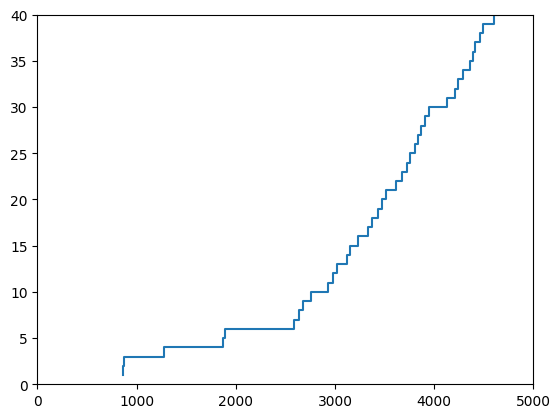

In [29]:
nickname = 'B1'
tf=LoadTraj(nickname+'-tf')
# make array of reward times in frames
re = np.array([y[0]+tf.fr[i,0] for i,r in enumerate(tf.re) for y in r])
# plot cumulative long paths, rewards, time in maze
ti=np.array(tf.fr.tolist()) # time in maze
ptn_1 = FindPathsToNode(116,tf,ma) # water
lmin=5 # minimal length
ptn_m = ptn_1[np.where(ptn_1[:,2]>=lmin)] # impose minimal length

x_water = [TimeInMaze(p,tf) for p in ptn_m[:,3]]
y_water = np.arange(len(ptn_m))+1
plt.step(x_water, y_water)

"""x=[TimeInMaze(p,tf) for p in re]
y=np.arange(len(re))+1
plot(x,y,fmts=['g'],markersize=8,axes=ax,
        xlabel='Time in maze (s)',
        ylabel='Paths of length>={}'.format(lmin),
        legend=['to water','to control nodes','rewards'],
        xlim=[0,5000],ylim=[0,40]); # cumulative rewards"""
plt.xlim(0, 5000)
plt.ylim(0,40)
print(nickname)
plt.show()

(array([ 3.,  2.,  8., 15., 12., 20., 22., 17., 27., 10.]),
 array([ 858.8       , 1621.48666667, 2384.17333333, 3146.86      ,
        3909.54666667, 4672.23333333, 5434.92      , 6197.60666667,
        6960.29333333, 7722.98      , 8485.66666667]),
 <BarContainer object of 10 artists>)

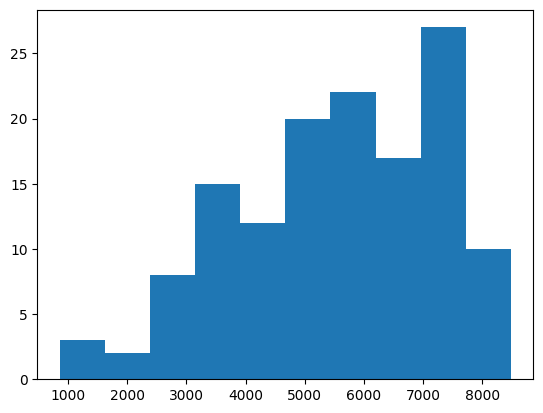

In [33]:
lp_times = np.array([TimeInMaze(p,tf) for p in ptn_m[:,3]])
plt.hist(lp_times)

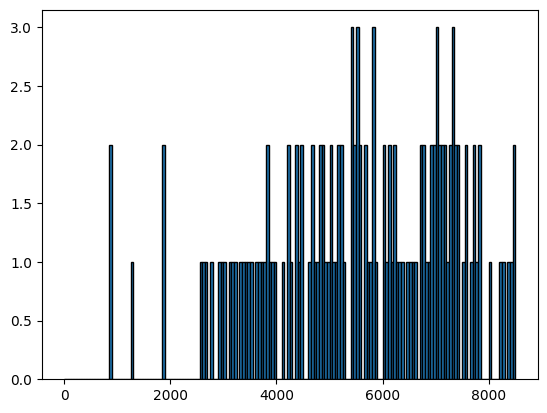

171


In [66]:
w = 50  # desired bin width
bins = np.arange(0, max(lp_times) + w, w)
plt.hist(lp_times, bins=bins, edgecolor='black')
plt.show()
print(len(bins))

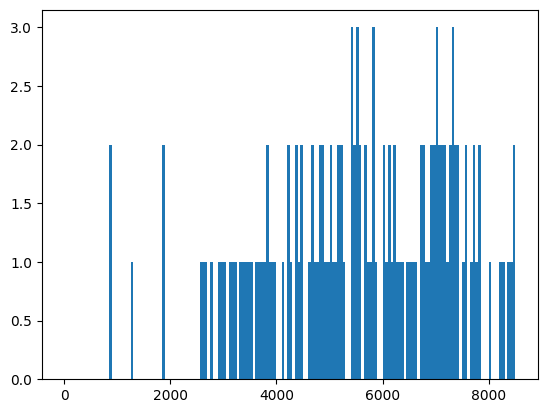

0.8


In [81]:
bins = np.arange(0, max(lp_times) + w, w)
lpn = len(bins)
lph = np.histogram(lp_times, bins=bins)

bin_edges = lph[1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, lph[0], width=w)
plt.show()
print(np.mean(lph[0]))

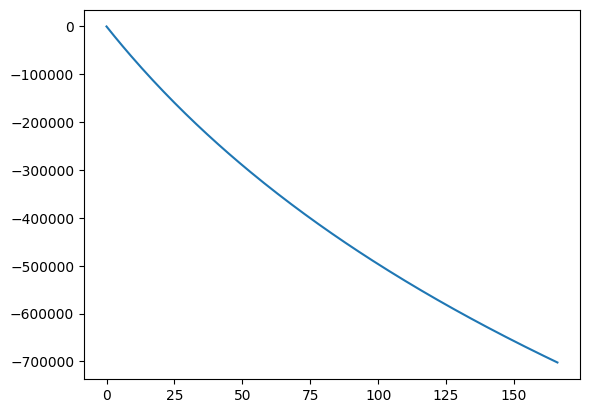

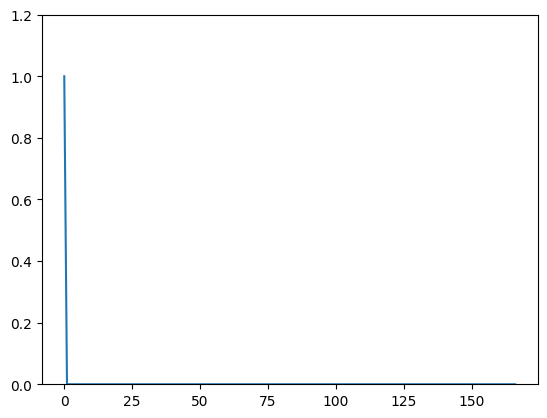

In [82]:
from bayes import *


alpha, beta = 50, 100
taus = np.zeros(lpn-4)
for s in range(2, lpn-2):
    taus[s-2] = P(1,s,lph,True, alpha=alpha, beta=beta) + P(s+1, lpn, lph, True, alpha=alpha, beta=beta) + np.log(6) - 3*np.log(lpn)+np.log(lpn-s)+np.log(lpn)+np.log(s-1)

print(len(lph), len(taus))
lmax = np.max(taus)
lz = lmax + np.log(np.sum(np.exp(taus-lmax)))
plt.plot(taus-lz)
plt.show()

plt.plot(np.exp(taus-lz))
plt.ylim(0,1.2)
plt.show()


In [65]:
lph

(array([2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2,
        2, 1, 0, 1, 2, 3, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1,
        1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 1, 2, 3, 2,
        2, 0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2]),
 array([ 858.8       ,  908.32510823,  957.85021645, 1007.37532468,
        1056.9004329 , 1106.42554113, 1155.95064935, 1205.47575758,
        1255.0008658 , 1304.52597403, 1354.05108225, 1403.57619048,
        1453.1012987 , 1502.62640693, 1552.15151515, 1601.67662338,
        1651.2017316 , 1700.72683983, 1750.25194805, 1799.77705628,
        1849.3021645 , 1898.82727273, 1948.35238095, 1997.87748918,
        2047.4025974 , 2096.92770563, 2146.45281385, 2195.97792208,
    